In [1]:
%matplotlib inline
"""Module containing velocity fields to test the preliminary model
"""

from __future__ import division
import numpy as np
import pylab as plb
import matplotlib.pyplot as plt
from math import pi

def zero(nz, nx):
	""" Produce a matrix of zeros on the input grid
	:arg nx: number of points in x dimension
	:arg nz: number of points in z dimension
	"""
	# store the solution in a matrix
	u = np.zeros([2, nz, nx])
	return u



def onecell_up(xmin, xmax, zmin, zmax, nx, nz, V):
        """ u_simple computes a simple rotational, divergenceless flow field on a specified grid
        :arg xmin: minimum x on the grid
        :arg xmax: maximum x on the grid
        :arg zmin: minimum z on the grid
        :arg zmax: maximum z on the grid
        :arg nx: number of points in x dimension
        :arg nz: number of points in z dimension	
        """
        # define velocity on square grid, then scale onto rectangular grid. 
        a = zmax
        b = zmax
        x = np.linspace(-a/2, a/2, nx)
        hdz = 0.5*b/nz
        z = np.linspace(-b/2-hdz, b/2+hdz, nz+1)
        [xx, zz] = np.meshgrid(x, z)
        dx = (xmax - xmin) / (nx - 1)
        dz = (zmax - zmin) / (nz - 1)
        rr = np.sqrt(xx**2 + zz**2)
        idx = rr < a/2
        uz = np.zeros([nz+1, nx])
        uz[idx] = np.sin(2*pi*rr[idx] / a) / rr[idx] * xx[idx]

        # remove nans
        nanfill = np.zeros((nz, nx))
        id_nan = np.isnan(uz)
        uz[id_nan] = nanfill[id_nan]

        # make sure top two and bottom two rows are zero
        uz[0:2,:] = 0.
        uz[nz-1:nz+1,:] = 0.

        # scale & store the solution in a matrix, shifting up and down
        u = np.zeros([2, nz, nx])
        u[0, :, :nx/2] = uz[0:nz, :nx/2] / np.max(uz) * V * zmax/xmax
        u[0, :, nx/2:] = uz[1:, nx/2:] / np.max(uz) * V * zmax/xmax

        # extract components for upstream correction
        uz = u[0, :, :]
        ux = np.zeros((nz,nx))
        
        # define upstream as the sum of two adjacent grid point vel.s
        p_upz = np.sign(uz[:-1]+uz[1:])*0.5*( np.sign(uz[:-1]+uz[1:]) - 1)
        n_upz = np.sign(uz[:-1]+uz[1:])*0.5*( np.sign(uz[:-1]+uz[1:]) + 1)

        # z > 0, ux > 0
        i = np.arange(1, nz/2, 1, dtype = int)
        j = 1
        while j <= nx-2:
            # note shift in p_upz and n_upz
            ux[i, j] = ux[i, j - 1] + dx/dz* (( uz[i,j] - uz[i + 1, j])*p_upz[i, j] + (uz[i - 1, j] - uz[i,j])*n_upz[i-1, j])
            j += 1

        # z < 0, ux < 0
        i = np.arange(nz/2, nz - 1, 1, dtype = int)
        j = nx - 2
        while j >= 1:
            
            ux[i, j] = ux[i, j + 1] - dx/dz* ((uz[i,j] - uz[i + 1, j]) *p_upz[i, j] + (uz[i - 1, j] - uz[i,j])*n_upz[i-1, j])
            j -= 1

        # store result
        u[1, :, :] = ux

        return u

def twocell_up(xmin, xmax, zmin, zmax, nx, nz, V):
	""" u_complex complex computes a rotational, downwelling velocity field
	:arg xmin: minimum x on the grid
	:arg xmax: maximum x on the grid
	:arg zmin: minimum z on the grid
	:arg zmax: maximum z on the grid
	:arg nx: number of points in x dimension
	:arg nz: number of points in z dimension
	"""
	# define a grid that will produce downwelling
	a = zmax
	b = zmax
	x = np.zeros(nx)
        x[0:nx/2] = np.linspace(-a/2, a/2, nx/2)
        x[nx/2:] = np.linspace(a/2, -a/2, nx/2)
        hdz = 0.5*b/nz
        z = np.linspace(-b/2-hdz, b/2+hdz, nz+1)
	[xx, zz] = np.meshgrid(x, z)
	zz[0:, nx/2:] = - zz[0:, nx/2:]  
	rr = np.sqrt(xx**2 + zz**2)
	ux = np.zeros((nz+1, nx))
	uz = np.zeros((nz+1, nx))
	idx = rr < a/2
        # z velocity
        uz[idx] = np.sin(2*pi*rr[idx] / a) / rr[idx] * xx[idx]
        '''if we add a negative sign above, it could become a upwelling'''
        # remove nans
        nanfill = np.zeros((nz, nx))
        id_nan = np.isnan(uz)
        uz[id_nan] = nanfill[id_nan]
        # make sure top two and bottom two rows are zero
        uz[0:2,:] = 0.
        uz[nz-1:nz+1,:] = 0.
        # scale & store the solution in a matrix, shifting up and down
        u = np.zeros([2, nz, nx])
        u[0, :, :nx/4] = uz[0:nz, :nx/4] / np.max(uz) * V * zmax/xmax
        u[0, :, nx/4:] = uz[1:, nx/4:] / np.max(uz) * V * zmax/xmax
        u[0, :, nx/2:] = uz[1:, nx/2:] / np.max(uz) * V * zmax/xmax
        u[0, :, 3*nx/4:] = uz[0:nz, 3*nx/4:] / np.max(uz) * V * zmax/xmax

        # extract velocities for redefinition
        ux = u[1, :,:]
        uz = u[0, :,:]

        # define upstream
        p_upz = np.sign(uz[:-1, :]+uz[1:, :])*0.5*( np.sign(uz[:-1, :]+uz[1:, :]) - 1)
        n_upz = np.sign(uz[:-1, :]+uz[1:, :])*0.5*( np.sign(uz[:-1, :]+uz[1:, :]) + 1)
        p_upx = np.sign(ux[:, :-1]+ux[:, 1:])*0.5*( np.sign(ux[:, :-1]+ux[:, 1:]) - 1)
        n_upx = np.sign(ux[:, :-1]+ux[:, 1:])*0.5*( np.sign(ux[:, :-1]+ux[:, 1:]) + 1)

        # spatial step
        dx = (xmax - xmin) / (nx - 1)
        dz = (zmax - zmin) / (nz - 1)

        # vectorize region z > 0
        i = np.arange(1, nz/2, 1, dtype = int)
        j = 1
        while j <= nx/2:
            ux[i, j] = ux[i, j - 1] + dx/dz * ((uz[i - 1, j] - uz[i, j])*n_upz[i - 1, j] + (uz[i, j] - uz[i + 1, j])*p_upz[i, j])
            j += 1

        j = nx - 2
        while j >= nx/2:
            ux[i, j] = ux[i, j + 1] - dx/dz * ((uz[i - 1, j] - uz[i, j])*n_upz[i - 1, j] + (uz[i, j] - uz[i + 1, j])*p_upz[i, j])
            j -= 1

        # vectorize region z < 0
        i = np.arange(nz/2, nz - 1, 1, dtype = int)
        j = nx/2 - 2
        while j >= 1:
            ux[i, j] = ux[i, j + 1] - dx/dz * ((uz[i - 1, j] - uz[i, j])*n_upz[i - 1, j] + (uz[i, j] - uz[i + 1, j])*p_upz[i, j])
            j -= 1

        j = nx/2 + 1
        while j <= nx - 2:
            ux[i, j] = ux[i, j - 1] + dx/dz * ((uz[i - 1, j] - uz[i, j])*n_upz[i - 1, j] + (uz[i, j] - uz[i + 1, j])*p_upz[i, j])
            j += 1
            
        # store solution
        u[1, :,:] = ux
        
        return u
    

630.72


/home/xiaoxiny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:101: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/xiaoxiny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:102: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/xiaoxiny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:106: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/xiaoxiny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:112: RuntimeWarning: invalid value encountered in true_divide
/home/xiaoxiny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:123: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/xiaoxiny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:124: DeprecationWarning: using a non-integer n

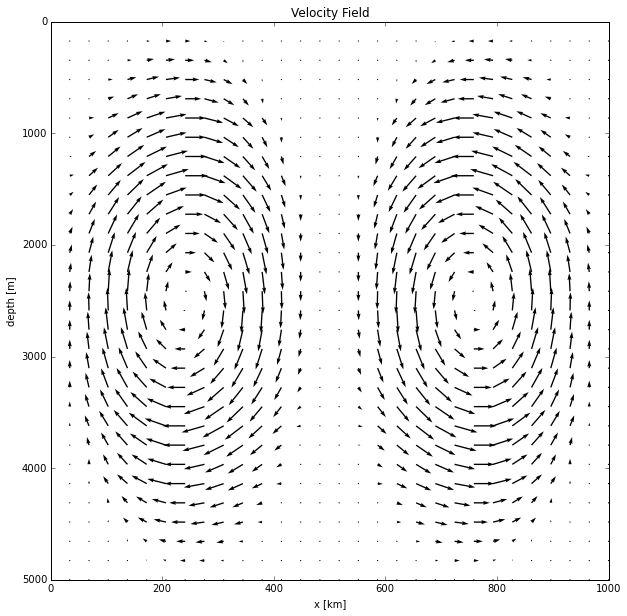

In [2]:
V = 0.02/1000*365.*86400.
xmin=0
xmax=1e6
zmin=0
zmax=5e3
nx=30
nz=30


u =twocell_up(xmin, xmax, zmin, zmax, nx, nz, V)

print V

x = np.linspace(xmin, xmax, nx)
z = np.linspace(zmin, zmax, nz)
flowfig = plb.figure(figsize = (10,10))	
plb.quiver(x/1e3, z, u[1,:,:], -100*u[0,:,:])#1=ux,0=uz
plb.gca().invert_yaxis()
plt.title('Velocity Field')
plt.xlabel('x [km]')
plt.ylabel('depth [m]')
plt.show()

630.72


/home/xiaoxiny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:101: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/xiaoxiny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:102: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/xiaoxiny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:106: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/xiaoxiny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:112: RuntimeWarning: invalid value encountered in true_divide
/home/xiaoxiny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:123: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/xiaoxiny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:124: DeprecationWarning: using a non-integer n

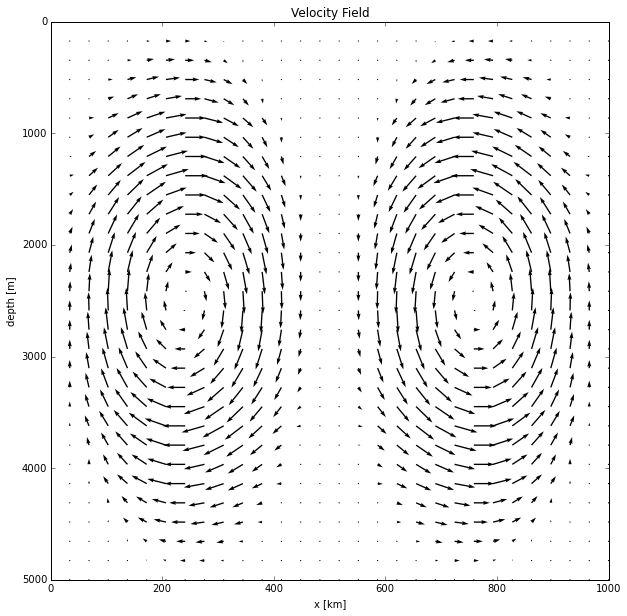

In [3]:
V = 0.02/1000*365.*86400.
xmin=0
xmax=1e6
zmin=0
zmax=5e3
nx=30
nz=30


u =twocell_up(xmin, xmax, zmin, zmax, nx, nz, V)

print V

x = np.linspace(xmin, xmax, nx)
z = np.linspace(zmin, zmax, nz)
flowfig = plb.figure(figsize = (10,10))	
plb.quiver(x/1e3, z, u[1,:,:], -100*u[0,:,:])#1=ux,0=uz
plb.gca().invert_yaxis()
plt.title('Velocity Field')
plt.xlabel('x [km]')
plt.ylabel('depth [m]')
plt.show()

630.72


/home/xiaoxiny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:56: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/xiaoxiny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:57: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


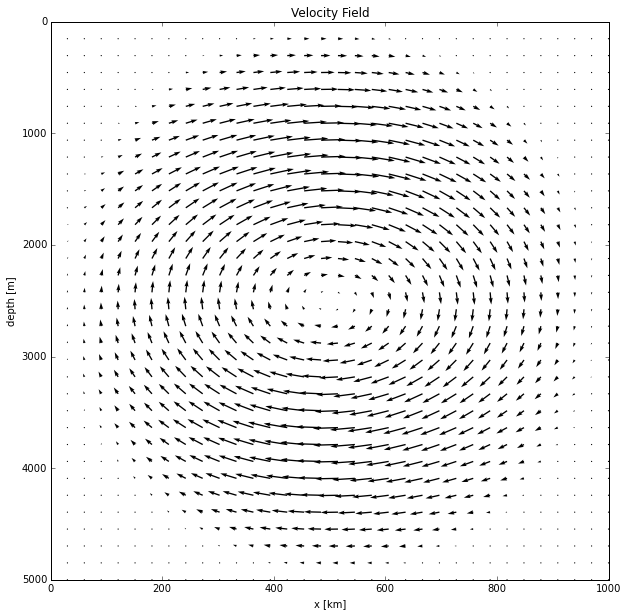

In [8]:
V = 0.02/1000*365.*86400.
xmin = 0
xmax = 1e6
zmin = 0
zmax = 5e3
nz = 34
nx = 34
#ng = 1

u =onecell_up(xmin, xmax, zmin, zmax, nx, nz, V)

print V

x = np.linspace(xmin, xmax, nx)
z = np.linspace(zmin, zmax, nz)
flowfig = plb.figure(figsize = (10,10))	
plb.quiver(x/1e3, z, u[1,:,:], -100*u[0,:,:])
plb.gca().invert_yaxis()
plt.title('Velocity Field')
plt.xlabel('x [km]')
plt.ylabel('depth [m]')
plt.show()

In [7]:
print u[0,:,:].max()

3.1536
